In [ ]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

After preprocessing data we store into final.sqlite and using it 

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')


In [ ]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

## Time based Splitting Test and Train

In [0]:
final=final.sort_values(by=['Time'],ascending=False)
finalDataPoints=final.head(100000)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

x=finalDataPoints["CleanedText"]
y=finalDataPoints["Score"]
x_1,x_test,y_1,y_test=train_test_split(x, y, test_size=0.2,shuffle=False)

In [79]:
print(x_1.shape,x_test.shape,y_1.shape,y_test.shape)

(48000,) (12000,) (48000,) (12000,)


In [0]:
x_tr,x_cv,y_tr,y_cv=train_test_split(x_1,y_1,test_size=0.25,shuffle=False)

In [81]:
print(x_tr.shape,y_tr.shape,x_cv.shape,y_cv.shape,x_test.shape,y_test.shape)

(36000,) (36000,) (12000,) (12000,) (12000,) (12000,)


# 1.Bag of Words (BoW)

## 1.1 Unigram

In [0]:
#BOW for unigram
bow = CountVectorizer()
x_tr = bow.fit_transform(x_tr)
x_test = bow.transform(x_test)
x_cv = bow.transform(x_cv)

### 1.1.1 Finding the optimal K

In [37]:
from sklearn.metrics import f1_score
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
scores=[]
for i in neighbors:
    # instantiate learning model (k = 30)
    Knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    Knn.fit(x_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = Knn.predict(x_cv)
    # evaluate CV accuracy
    score = f1_score(y_cv, pred,average='micro')
    scores.append(score)
    
MSE = [1 - x for x in scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 7.


### 1.1.2ploting confusion matrix and finding f1_score given optimal Value of K

Accuracy on test set: 83.858%
Precision on test set: 0.747
Recall on test set: 0.540
F1-Score on test set: 0.534
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



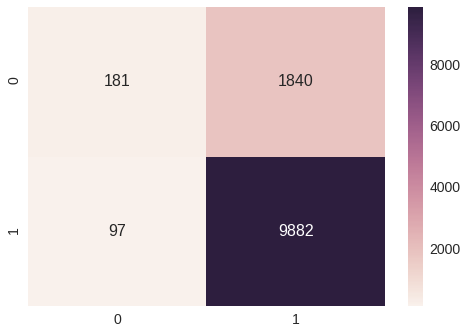

In [38]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(x_tr,y_tr)
y_pred = knn.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 1.2 Bi-Grams


### 1.2.1 Finding the optimal K

In [44]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr = bi_gram.fit_transform(x_tr)

x_test = bi_gram.transform(x_test)
x_cv = bi_gram.transform(x_cv)
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
scores=[]
for i in neighbors:
    # instantiate learning model (k = 30)
    Knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    Knn.fit(x_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = Knn.predict(x_cv)
    # evaluate CV accuracy
    score = f1_score(y_cv, pred,average='micro')
    scores.append(score)
    
MSE = [1 - x for x in scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)





The optimal number of neighbors is 9.


### 1.2.2 ploting confusion matrix and finding f1_score given optimal Value of K

Accuracy on test set: 83.400%
Precision on test set: 0.715
Recall on test set: 0.518
F1-Score on test set: 0.492
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



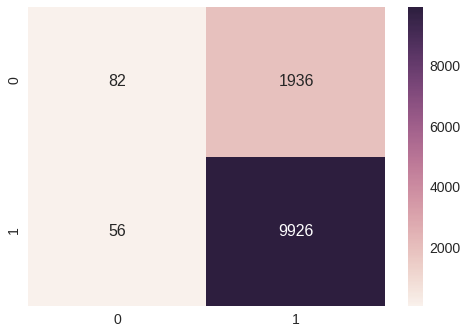

In [45]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(x_tr,y_tr)
y_pred = knn.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 2.TF-IDF

## 2.1 Finding the optimal K

In [48]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr = tf_idf_vect.fit_transform(x_tr)
x_test = tf_idf_vect.transform(x_test)
x_cv = tf_idf_vect.transform(x_cv)

myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
scores=[]
for i in neighbors:
    # instantiate learning model (k = 30)
    Knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    Knn.fit(x_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = Knn.predict(x_cv)
    # evaluate CV accuracy
    score = f1_score(y_cv, pred,average='micro')
    scores.append(score)
    
MSE = [1 - x for x in scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 11.


## 2.2 ploting confusion matrix and finding f1_score given optimal Value of K

Accuracy on test set: 84.808%
Precision on test set: 0.816
Recall on test set: 0.564
F1-Score on test set: 0.574
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



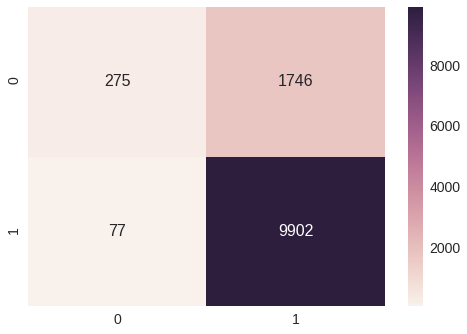

In [52]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(x_tr,y_tr)
y_pred = knn.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 3.Word2Vec

In [0]:
i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())
  
i=0
list_of_sent_cv=[]
for sent in x_cv:
    list_of_sent_cv.append(sent.split())
      
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [85]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7857
sample words  ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'hard', 'ever', 'write', 'review', 'rice', 'good', 'live', 'hawaii', 'never', 'seen', 'caribbean', 'sale', 'store', 'came', 'across', 'search', 'amazon', 'glad', 'gave', 'think', 'youll', 'disappoint', 'ad', 'chop', 'chicken', 'suggest', 'also', 'small', 'onion', 'unbeliev', 'anoth', 'great', 'way', 'make', 'even', 'better', 'fresh']


# 4.Avg W2V

In [86]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

36000
50


In [87]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

12000
50


In [88]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

12000
50


## 4.1 Finding the optimal K

In [76]:
x_test=sent_vectors_test
x_cv=sent_vectors_cv
x_tr=sent_vectors
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
scores=[]
for i in neighbors:
    # instantiate learning model (k = 30)
    Knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    Knn.fit(x_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = Knn.predict(x_cv)
    # evaluate CV accuracy
    score = f1_score(y_cv, pred,average='micro')
    scores.append(score)
    
MSE = [1 - x for x in scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 11.


## 4.2 ploting confusion matrix and finding f1_score given optimal Value of K

Accuracy on test set: 86.475%
Precision on test set: 0.794
Recall on test set: 0.652
F1-Score on test set: 0.687


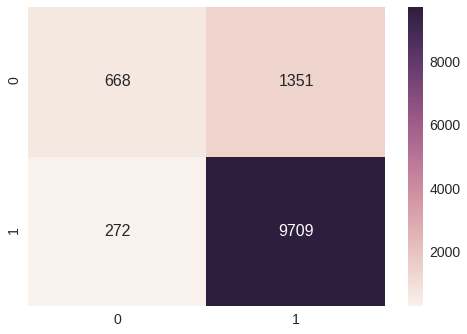

In [77]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(x_tr,y_tr)
y_pred = knn.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 5.TFIDF-W2V

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_tr)
final_tf_idf_test = tf_idf_vect.transform(x_test)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [90]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 36000/36000 [00:54<00:00, 661.92it/s]


In [91]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 12000/12000 [00:19<00:00, 601.83it/s]


In [92]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 12000/12000 [00:20<00:00, 594.00it/s]


## 5.1 Finding the optimal K

In [93]:
x_test=tfidf_sent_vectors_test
x_cv=tfidf_sent_vectors_cv
x_tr=tfidf_sent_vectors
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
scores=[]
for i in neighbors:
    # instantiate learning model (k = 30)
    Knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    Knn.fit(x_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = Knn.predict(x_cv)
    # evaluate CV accuracy
    score = f1_score(y_cv, pred,average='micro')
    scores.append(score)
    
MSE = [1 - x for x in scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)




The optimal number of neighbors is 15.


## 5.2 ploting confusion matrix and finding f1_score given optimal Value of K

Accuracy on test set: 85.458%
Precision on test set: 0.772
Recall on test set: 0.617
F1-Score on test set: 0.646


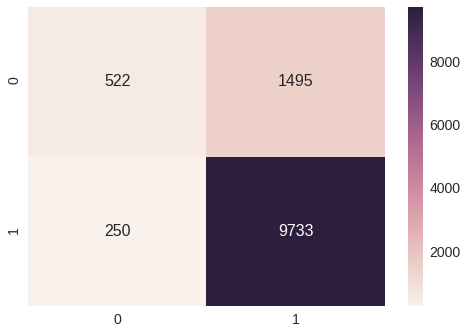

In [94]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(x_tr,y_tr)
y_pred = knn.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Conclusion
| Model | hyper parameter   |F1-score  TEST|Accuracy score TEST
|------|------|------|------|
|  unigram  | 7| 0.534|83.858%|
| Bi-gram | 9| 0.492|0.492%|
|  Tf-IDF | 11| 0.574|84.808%|
| Av-Word2Vec |11|0.687|86.475%|
|  Tf-IDF Word2vec | 17|0.646|85.458%|
